## **Deteksi Kanker Payudara Pada Citra Ultrasografi menggunakan Metode Neural Network dengan Ekstraksi Fitur Gray Level Cooccurrence Matrix (GLCM) dan Optimasi Fungsi Aktivasi ReLU Dan Adam**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **PRE-PROCESSING**

In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from scipy.stats import entropy
import pandas as pd


def preprocessing_ultrasound(image_path, output_folder):
    # Baca citra ultrasonografi
    image_ori = cv2.imread(image_path)

    # Konversi citra menjadi grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # 1. Pengurangan noise dengan Gaussian Blur
    blurred = cv2.GaussianBlur(image, (3, 3), 0)

    # 2. Thresholding untuk menghasilkan binary mask
    _, thresh = cv2.threshold(blurred, 30, 255, cv2.THRESH_BINARY_INV)

    # 3. Temukan kontur pada clean mask
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Inisialisasi variabel untuk kontur dengan area terbesar di luar area
    largest_contour_above = None
    largest_area_above = 0

    # Loop melalui semua kontur
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > largest_area_above:
            # Periksa apakah kontur berada di luar area bawah gambar
            if cv2.pointPolygonTest(contour, (image.shape[1] / 2, image.shape[0]), False) < 0:
                largest_area_above = area
                largest_contour_above = contour

    # Buat citra hitam kosong
    output_mask = np.zeros_like(thresh)

    if largest_contour_above is not None:
        # Gambar kontur dengan area terbesar di luar area bawah pada citra output
        cv2.drawContours(output_mask, [largest_contour_above], -1, (255), thickness=cv2.FILLED)

        # Menampilkan hasil preprocessing
        plt.figure(figsize=(10, 10))
        plt.subplot(231), plt.imshow(image_ori, cmap='gray'), plt.title('Citra Asli')
        # plt.subplot(232), plt.imshow(image, cmap='gray'), plt.title('Grayscale')
        # plt.subplot(233), plt.imshow(blurred, cmap='gray'), plt.title('Gaussian Blur')
        plt.subplot(232), plt.imshow(output_mask, cmap='gray'), plt.title('Thresholding')

    if largest_contour_above is not None:
        # Gambar kontur dengan area terbesar di luar area bawah pada citra asli
        image_with_largest_contour = cv2.drawContours(image, [largest_contour_above], -1, (0, 255, 0), 2)
        # plt.subplot(235), plt.imshow(image_with_largest_contour, cmap='gray'), plt.title('Kontur')


    plt.show()

   # Menyimpan hasil output_mask ke folder output di Google Drive
    output_image_path = os.path.join(output_folder, os.path.basename(image_path))
    cv2.imwrite(output_image_path, output_mask)

    return thresh  # Mengembalikan hasil akhir yang ingin digunakan

def clear_output_folder(output_folder):
    # Hapus semua file dalam folder output
    for filename in os.listdir(output_folder):
        file_path = os.path.join(output_folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(f'Gagal menghapus {file_path}. Reason: {e}')

print('---------------------Abnormal-Aug---------------------')
print(' ')
print(' ')

# Path ke folder berisi gambar citra ultrasonografi kanker payudara
input_folder_path = '/content/drive/My Drive/Colab Notebooks/DeteksiKanker/LargeDataset/abnormal-aug/'
output_folder_path = '/content/drive/My Drive/Colab Notebooks/DeteksiKanker/LargeDataset/preprop-abnormal/'  # Ganti dengan jalur folder Anda

# Pastikan folder output ada
os.makedirs(output_folder_path, exist_ok=True)

# Bersihkan folder output sebelum mulai menyimpan hasil baru
clear_output_folder(output_folder_path)

# List semua file dalam folder
image_files = os.listdir(input_folder_path)

# Iterasi melalui setiap gambar di folder
for image_file in image_files:
    # Menggabungkan path folder dengan nama file
    input_image_path = os.path.join(input_folder_path, image_file)

    # Melakukan preprocessing pada setiap gambar
    output_mask = preprocessing_ultrasound(input_image_path, output_folder_path)

print('---------------------Normal-Aug---------------------')
print(' ')
print(' ')

# Path ke folder berisi gambar citra ultrasonografi kanker payudara
input_folder_path2 = '/content/drive/My Drive/Colab Notebooks/DeteksiKanker/LargeDataset/normal-aug/'
output_folder_path2 = '/content/drive/My Drive/Colab Notebooks/DeteksiKanker/LargeDataset/preprop-normal/' # Ganti dengan jalur folder Anda

# Pastikan folder output ada
os.makedirs(output_folder_path2, exist_ok=True)

# Bersihkan folder output sebelum mulai menyimpan hasil baru
clear_output_folder(output_folder_path2)

# List semua file dalam folder
image_files2 = os.listdir(input_folder_path2)

# Iterasi melalui setiap gambar di folder
for image_file2 in image_files2:
    # Menggabungkan path folder dengan nama file
    input_image_path2 = os.path.join(input_folder_path2, image_file2)

    # Melakukan preprocessing pada setiap gambar
    output_mask2 = preprocessing_ultrasound(input_image_path2, output_folder_path2)

Output hidden; open in https://colab.research.google.com to view.

### **Fungsi Ektraksi GLCM**

In [3]:
import cv2
import numpy as np
import pandas as pd
import os

# Fungsi untuk menghitung GLCM
def calculate_glcm(image, distances=[1], angles=[0], levels=256):
    # Initialize GLCM matrices
    glcm_matrices = []

    for distance in distances:
        for angle in angles:
            # Calculate offset
            offset_x = int(distance * np.cos(angle))
            offset_y = int(distance * np.sin(angle))

            # Initialize GLCM matrix
            glcm = np.zeros((levels, levels), dtype=np.uint32)

            # Loop through image pixels
            for y in range(image.shape[0]):
                for x in range(image.shape[1]):
                    x_neighbor = x + offset_x
                    y_neighbor = y + offset_y

                    # Ensure neighbor is within image bounds
                    if 0 <= x_neighbor < image.shape[1] and 0 <= y_neighbor < image.shape[0]:
                        intensity_i = image[y, x]
                        intensity_j = image[y_neighbor, x_neighbor]
                        glcm[intensity_i, intensity_j] += 1

            # Normalize GLCM
            glcm = glcm.astype(np.float32) / np.sum(glcm)
            glcm_matrices.append(glcm)

    return glcm_matrices

# Fungsi untuk menghitung energi GLCM
def calculate_energy(glcm):
    return np.sum(glcm**2)

# Fungsi untuk menghitung kontrast GLCM
def calculate_contrast(glcm):
    contrast = 0
    levels = glcm.shape[0]
    for i in range(levels):
        for j in range(levels):
            contrast += (i - j)**2 * glcm[i, j]
    return contrast

# Fungsi untuk menghitung homogenitas GLCM
def calculate_homogeneity(glcm):
    homogeneity = 0
    levels = glcm.shape[0]
    for i in range(levels):
        for j in range(levels):
            homogeneity += glcm[i, j] / (1 + abs(i - j))
    return homogeneity

# Fungsi untuk menghitung entropi GLCM
def calculate_entropy(glcm):
    return -np.sum(glcm * np.log2(glcm + np.finfo(float).eps))

## Ekstraksi Fitur Abnormal (Kanker)

In [4]:
from scipy.stats import entropy

# Path ke direktori gambar
image_directory = '/content/drive/My Drive/Colab Notebooks/DeteksiKanker/LargeDataset/preprop-abnormal/'

# List untuk menyimpan hasil fitur GLCM
glcm_features_list_abnormal = []

# Iterasi melalui semua file dalam direktori
for filename in os.listdir(image_directory):
    if filename.endswith(".png"):  # Pastikan hanya file berformat .png yang diambil
        # Load citra dari file
        image_path = os.path.join(image_directory, filename)
        usg_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Pastikan citra berhasil dimuat
        if usg_image is not None:
            # Hitung GLCM dan fitur tekstur
            glcm_matrices = calculate_glcm(usg_image, distances=[1], angles=[0], levels=256)

            # Hitung fitur tekstur untuk setiap GLCM matrix
            for i, glcm in enumerate(glcm_matrices):
                energy = calculate_energy(glcm)
                contrast = calculate_contrast(glcm)
                homogeneity = calculate_homogeneity(glcm)
                entropy = calculate_entropy(glcm)

                # Simpan fitur dalam bentuk dictionary
                glcm_features = {
                    'Energy': energy,
                    'Contrast': contrast,
                    'Homogeneity': homogeneity,
                    'Entropy': entropy,
                    'Label': '1'
                }

                # Tambahkan ke list hasil
                glcm_features_list_abnormal.append(glcm_features)

# Buat DataFrame dari list fitur GLCM
data_glcm_abnormal = pd.DataFrame(glcm_features_list_abnormal)


# Simpan DataFrame ke dalam file CSV
# csv_filename = 'glcm_abnormal.csv'
# data1.to_csv(csv_filename, index=False)

# Tampilkan DataFrame
print(data_glcm_abnormal)

# Tampilkan pesan sukses
# print(f"Hasil ekstraksi fitur GLCM telah disimpan dalam file {csv_filename}")


       Energy    Contrast  Homogeneity   Entropy Label
0    0.771503  132.244936     0.997974  0.577837     1
1    0.829380  174.693943     0.997324  0.469525     1
2    0.657618  100.945333     0.998454  0.772584     1
3    0.606603  492.684792     0.992453  0.891271     1
4    0.861645   65.844800     0.998991  0.391896     1
..        ...         ...          ...       ...   ...
642  0.775586  126.357307     0.998064  0.569684     1
643  0.559206  345.018086     0.994715  0.951759     1
644  0.635781  217.956588     0.996661  0.820350     1
645  0.575721  244.727928     0.996251  0.917302     1
646  0.716047  183.782812     0.997185  0.682681     1

[647 rows x 5 columns]


In [5]:
from scipy.stats import entropy

# Inisialisasi list untuk menyimpan fitur
feature_list_abnormal = []

# Iterasi melalui semua file dalam direktori
for filename in os.listdir(image_directory):
    if filename.endswith(".png"):  # Pastikan hanya file berformat .png yang diambil
        # Load citra dari file
        image_path = os.path.join(image_directory, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Pastikan citra berhasil dimuat
        if image is not None:
            # Hitung 'Energy'
            energy = np.sum(image ** 2)

            # Hitung 'Contrast' (varians)
            contrast = np.var(image)

            # Hitung 'Homogeneity'
            diffs = np.diff(image.astype(np.float32), axis=0)
            homogeneity = np.mean(1 / (1 + np.abs(diffs)))

            # Hitung 'Entropy'
            hist, _ = np.histogram(image, bins=256, range=[0, 256], density=True)
            hist += 1e-10  # Hindari nilai nol untuk perhitungan entropy
            ent = entropy(hist)

            # Simpan fitur dalam bentuk dictionary
            features = {
                'Energy': energy,
                'Contrast': contrast,
                'Homogeneity': homogeneity,
                'Entropy': ent,
                'Label': '1'  # Sesuaikan label sesuai kebutuhan
            }

            # Tambahkan ke list hasil
            feature_list_abnormal.append(features)


# Buat DataFrame dari list fitur
data_non_glcm_abnormal = pd.DataFrame(feature_list_abnormal)

# Tampilkan DataFrame
print(data_non_glcm_abnormal)


     Energy      Contrast  Homogeneity   Entropy Label
0     66766   7368.269999     0.995562  0.386938     1
1     41581   5463.007946     0.994394  0.308481     1
2    126098  11083.863987     0.996572  0.524319     1
3     39785  12523.559403     0.987743  0.573485     1
4     29593   4459.368215     0.998636  0.264029     1
..      ...           ...          ...       ...   ...
642   58523   7225.330403     0.996555  0.381278     1
643   87150  14167.151071     0.992756  0.627440     1
644   63804  11720.550201     0.992804  0.546299     1
645   62045  13670.978331     0.993423  0.611377     1
646   59983   9130.488354     0.994112  0.454240     1

[647 rows x 5 columns]


## Ekstraksi Fitur Normal (Non- Kanker)

In [6]:
# Path ke direktori gambar
image_directory2 = '/content/drive/My Drive/Colab Notebooks/DeteksiKanker/LargeDataset/preprop-normal/'

# List untuk menyimpan hasil fitur GLCM
glcm_features_list2 = []

# Iterasi melalui semua file dalam direktori
for filename in os.listdir(image_directory2):
    if filename.endswith(".png"):  # Pastikan hanya file berformat .png yang diambil
        # Load citra dari file
        image_path = os.path.join(image_directory2, filename)
        usg_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Pastikan citra berhasil dimuat
        if usg_image is not None:
            # Hitung GLCM dan fitur tekstur
            glcm_matrices = calculate_glcm(usg_image, distances=[1], angles=[0], levels=256)

            # Hitung fitur tekstur untuk setiap GLCM matrix
            for i, glcm in enumerate(glcm_matrices):
                energy = calculate_energy(glcm)
                contrast = calculate_contrast(glcm)
                entropy = calculate_entropy(glcm)

                # Simpan fitur dalam bentuk dictionary
                glcm_features = {
                    'Energy': energy,
                    'Contrast': contrast,
                    'Homogeneity': homogeneity,
                    'Entropy': entropy,
                    'Label': '0'
                }

                # Tambahkan ke list hasil
                glcm_features_list2.append(glcm_features)

# Buat DataFrame dari list fitur GLCM
data_glcm_normal = pd.DataFrame(glcm_features_list2)

# # Simpan DataFrame ke dalam file CSV
# csv_filename = 'glcm_normal.csv'
# data0.to_csv(csv_filename, index=False)

# # Tampilkan DataFrame
print(data_glcm_normal)

# # Tampilkan pesan sukses
# print(f"Hasil ekstraksi fitur GLCM telah disimpan dalam file {csv_filename}")


       Energy    Contrast  Homogeneity   Entropy Label
0    0.723056  172.474437     0.994112  0.669147     0
1    0.644773  244.981425     0.994112  0.808379     0
2    0.903018  127.966614     0.994112  0.304351     0
3    0.781449  160.742757     0.994112  0.562017     0
4    0.821651  270.514908     0.994112  0.493146     0
..        ...         ...          ...       ...   ...
128  0.862995  148.424043     0.994112  0.396846     0
129  0.591773  213.322050     0.994112  0.889444     0
130  0.955298   69.041545     0.994112  0.164403     0
131  0.998774    8.072746     0.994112  0.007999     0
132  0.801037  143.698891     0.994112  0.522910     0

[133 rows x 5 columns]


In [7]:
from scipy.stats import entropy

feature_list_normal = []


# Iterasi melalui semua file dalam direktori
for filename in os.listdir(image_directory2):
    if filename.endswith(".png"):  # Pastikan hanya file berformat .png yang diambil
        # Load citra dari file
        image_path = os.path.join(image_directory2, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Pastikan citra berhasil dimuat
        if image is not None:
            # Hitung 'Energy'
            energy = np.sum(image ** 2)

            # Hitung 'Contrast' (varians)
            contrast = np.var(image)

            # Hitung 'Homogeneity'
            diffs = np.diff(image.astype(np.float32), axis=0)
            homogeneity = np.mean(1 / (1 + np.abs(diffs)))

            # Hitung 'Entropy'
            hist, _ = np.histogram(image, bins=256, range=[0, 256], density=True)
            hist += 1e-10  # Hindari nilai nol untuk perhitungan entropy
            ent = entropy(hist)

            # Simpan fitur dalam bentuk dictionary
            features = {
                'Energy': energy,
                'Contrast': contrast,
                'Homogeneity': homogeneity,
                'Entropy': ent,
                'Label': '0'  # Sesuaikan label sesuai kebutuhan
            }

            # Tambahkan ke list hasil
            feature_list_normal.append(features)


# Buat DataFrame dari list fitur
data_non_glcm_normal = pd.DataFrame(feature_list_normal)

print(data_non_glcm_normal)

     Energy      Contrast  Homogeneity   Entropy Label
0     65044   8925.131469     0.993487  0.446615     0
1     60841  11442.010553     0.994395  0.536731     0
2     13142   3107.684365     0.996598  0.199471     0
3     54615   7026.506764     0.994819  0.373349     0
4     37398   5665.832084     0.989464  0.317173     0
..      ...           ...          ...       ...   ...
128   28795   4378.036464     0.994682  0.260311     0
129   74465  13163.588586     0.994173  0.594753     0
130    8872   1420.377997     0.997834  0.107022     0
131     222     35.771570     0.999772  0.004682     0
132   28779   6396.354857     0.995795  0.347769     0

[133 rows x 5 columns]


In [8]:
# # Unduh hasil GLCM
# from google.colab import files

# csv_filename = 'glcm_abnormal.csv'

# # Unduh file CSV
# files.download(csv_filename)

# Implementation ANN

## Prossed Data For Neural Network (**Backpropagation**)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [10]:
dataset_glcm = pd.concat([data_glcm_abnormal, data_glcm_normal ], ignore_index=True)
dataset_non_glcm =  pd.concat([data_non_glcm_abnormal, data_non_glcm_normal ], ignore_index=True)
print(dataset_glcm)
print(dataset_non_glcm)

       Energy    Contrast  Homogeneity   Entropy Label
0    0.771503  132.244936     0.997974  0.577837     1
1    0.829380  174.693943     0.997324  0.469525     1
2    0.657618  100.945333     0.998454  0.772584     1
3    0.606603  492.684792     0.992453  0.891271     1
4    0.861645   65.844800     0.998991  0.391896     1
..        ...         ...          ...       ...   ...
775  0.862995  148.424043     0.994112  0.396846     0
776  0.591773  213.322050     0.994112  0.889444     0
777  0.955298   69.041545     0.994112  0.164403     0
778  0.998774    8.072746     0.994112  0.007999     0
779  0.801037  143.698891     0.994112  0.522910     0

[780 rows x 5 columns]
     Energy      Contrast  Homogeneity   Entropy Label
0     66766   7368.269999     0.995562  0.386938     1
1     41581   5463.007946     0.994394  0.308481     1
2    126098  11083.863987     0.996572  0.524319     1
3     39785  12523.559403     0.987743  0.573485     1
4     29593   4459.368215     0.998636  0

In [11]:
# # Gabungkan kedua dataset
# dataset = pd.concat([dt1, dt2], ignore_index=True)

# # Simpan dataset gabungan ke dalam file CSV
# dataset.to_csv("dataset.csv", index=False)

# # Mengacak seluruh DataFrame =1 artinya mengacak 100%, cth. 0,5 brrti 50% data
# df = dataset.sample(frac=1)


In [12]:
# # # Gabungkan kedua dataset
# dataset = pd.concat([data0, data1], ignore_index=True)
# print(dataset)

In [13]:
dfg = dataset_glcm
dfg

,Energy,Contrast,Homogeneity,Entropy,Label
0,0.771503,132.244936,0.997974,0.577837,1
1,0.829380,174.693943,0.997324,0.469525,1
2,0.657618,100.945333,0.998454,0.772584,1
3,0.606603,492.684792,0.992453,0.891271,1
4,0.861645,65.844800,0.998991,0.391896,1
...,...,...,...,...,...
775,0.862995,148.424043,0.994112,0.396846,0
776,0.591773,213.322050,0.994112,0.889444,0
777,0.955298,69.041545,0.994112,0.164403,0
778,0.998774,8.072746,0.994112,0.007999,0


In [14]:
dfng = dataset_non_glcm
dfng

,Energy,Contrast,Homogeneity,Entropy,Label
0,66766,7368.269999,0.995562,0.386938,1
1,41581,5463.007946,0.994394,0.308481,1
2,126098,11083.863987,0.996572,0.524319,1
3,39785,12523.559403,0.987743,0.573485,1
4,29593,4459.368215,0.998636,0.264029,1
...,...,...,...,...,...
775,28795,4378.036464,0.994682,0.260311,0
776,74465,13163.588586,0.994173,0.594753,0
777,8872,1420.377997,0.997834,0.107022,0
778,222,35.771570,0.999772,0.004682,0


In [15]:
dfg['Label'] = dfg['Label'].astype(int)
dfg.dtypes

Energy         float64
Contrast       float64
Homogeneity    float64
Entropy        float64
Label            int64
dtype: object

In [16]:
dfng['Label'] = dfng['Label'].astype(int)
dfng['Energy'] = dfng['Energy'].astype(float)
dfng.dtypes

Energy         float64
Contrast       float64
Homogeneity    float32
Entropy        float64
Label            int64
dtype: object

In [17]:
# Memisahkan variabel prediksi dan yang sudah diprediksi
feature_dfg=dfg[['Energy', 'Contrast', 'Homogeneity', 'Entropy']]
x_g = np.asarray(feature_dfg)
y_g = np.asarray(dfg['Label'])

In [18]:
# Memisahkan variabel prediksi dan yang sudah diprediksi
feature_dfng=dfng[['Energy', 'Contrast', 'Homogeneity', 'Entropy']]
x_ng = np.asarray(feature_dfng)
y_ng = np.asarray(dfng['Label'])

In [19]:
y_g

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [20]:
from sklearn.model_selection import train_test_split

# split data
x_train_g, x_test_g, y_train_g, y_test_g = train_test_split(x_g, y_g, test_size=0.3, random_state=2)

# split data
x_train_ng, x_test_ng, y_train_ng, y_test_ng = train_test_split(x_ng, y_ng, test_size=0.3, random_state=2)

In [21]:
#Menampilkan ukuran data
print(x_g.shape, x_train_g.shape, x_test_g.shape)

#Menampilkan ukuran data
print(x_ng.shape, x_train_ng.shape, x_test_ng.shape)

(780, 4) (546, 4) (234, 4)
(780, 4) (546, 4) (234, 4)


## Nomalisasi Data

In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# Normalisasi dengan Min-Max Scaling
x_train_std_g = scaler.fit_transform(x_train_g)
x_test_std_g = scaler.transform(x_test_g)

# Normalisasi dengan Min-Max Scaling
x_train_std_ng = scaler.fit_transform(x_train_ng)
x_test_std_ng = scaler.transform(x_test_ng)

print(x_train_g)
print("---------------------------------------------")
print(x_test_g)
print("---------------------------------------------")
print(x_train_ng)
print("---------------------------------------------")
print(x_test_ng)

[[9.56718074e-01 9.65029929e+01 9.98521707e-01 1.62397989e-01]
 [6.17136970e-01 2.90820836e+02 9.95545024e-01 8.57107928e-01]
 [8.01103940e-01 1.72396089e+02 9.97359129e-01 5.25333881e-01]
 ...
 [6.63475796e-01 2.81509430e+02 9.95687662e-01 7.81044217e-01]
 [6.82600066e-01 2.91139529e+02 9.95540142e-01 7.49908633e-01]
 [6.82846946e-01 1.75732710e+02 9.97308016e-01 7.38676547e-01]]
---------------------------------------------
[[5.25658625e-01 2.72948832e+02 9.95818799e-01 9.95421188e-01]
 [6.94455420e-01 1.70393274e+02 9.97389809e-01 7.18504469e-01]
 [6.70987351e-01 2.43244389e+02 9.96273830e-01 7.65050352e-01]
 [5.84430883e-01 1.55668605e+02 9.97615371e-01 8.94802825e-01]
 [5.39176104e-01 2.46551170e+02 9.96223174e-01 9.72809991e-01]
 [5.25810122e-01 2.56300007e+02 9.96073836e-01 9.93638312e-01]
 [7.91960997e-01 1.08502044e+02 9.98337898e-01 5.36742530e-01]
 [9.92906397e-01 1.54434157e+01 9.99763428e-01 3.55466037e-02]
 [9.49180561e-01 1.18475682e+02 9.98185115e-01 1.85485801e-01]
 [9

## Perhitungan METODE Neural Network (Backpropagation)

In [23]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # Inisialisasi weights dan biases
        self.weights_input_hidden = np.random.rand(input_size, hidden_size)
        self.biases_hidden = np.zeros((1, hidden_size))
        self.weights_hidden_output = np.random.rand(hidden_size, output_size)
        self.biases_output = np.zeros((1, output_size))

    def sigmoid(self, x):
        # Fungsi aktivasi sigmoid
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        # Turunan fungsi sigmoid
        return x * (1 - x)

    def forward(self, inputs):
        # forward propagation
        self.hidden_layer_input = np.dot(inputs, self.weights_input_hidden) + self.biases_hidden
        self.hidden_layer_output = self.sigmoid(self.hidden_layer_input)

        self.output_layer_input = np.dot(self.hidden_layer_output, self.weights_hidden_output) + self.biases_output
        self.predicted_output = self.sigmoid(self.output_layer_input)

        return self.predicted_output

    def backward(self, inputs, targets, learning_rate):
        # Menghitung error
        output_error = targets - self.predicted_output
        output_delta = output_error * self.sigmoid_derivative(self.predicted_output)

        # Menghitung error di hidden layer
        hidden_layer_error = output_delta.dot(self.weights_hidden_output.T)
        hidden_layer_delta = hidden_layer_error * self.sigmoid_derivative(self.hidden_layer_output)

        # Update weights dan biases
        self.weights_hidden_output += self.hidden_layer_output.T.dot(output_delta) * learning_rate
        self.biases_output += np.sum(output_delta, axis=0, keepdims=True) * learning_rate
        self.weights_input_hidden += inputs.T.dot(hidden_layer_delta) * learning_rate
        self.biases_hidden += np.sum(hidden_layer_delta, axis=0, keepdims=True) * learning_rate

    def train(self, inputs, targets, epochs, learning_rate, tolerance=1e-5):
        mses = []  # List untuk menyimpan nilai loss pada setiap epoch
        prev_loss = float('inf')  # Inisialisasi nilai loss sebelumnya dengan infinitas
        for epoch in range(epochs):
            temp_mses = []  # List sementara untuk menyimpan nilai loss pada setiap data pelatihan dalam satu epoch
            # Lakukan forward dan backward propagation untuk setiap epoch
            for i in range(len(inputs)):
                input_data = inputs[i:i+1]
                target = targets[i:i+1]
                self.forward(input_data)
                self.backward(input_data, target, learning_rate)
                # Hitung error dan tambahkan ke list sementara
                loss = np.mean(np.square(target - self.predicted_output))
                temp_mses.append(loss)
            # Hitung rata-rata loss dari semua data pelatihan dalam satu epoch
            epoch_loss = sum(temp_mses) / len(temp_mses)
            mses.append(epoch_loss)

            # Cetak informasi mengenai iterasi epoch
            print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')

            # Berhenti jika perbedaan antara loss saat ini dan sebelumnya lebih kecil dari tolerance
            if abs(epoch_loss - prev_loss) < tolerance:
                print(f'Training converged at epoch {epoch + 1}')
                break
            prev_loss = epoch_loss
        return mses

## Perhitungan METODE Neural Network (Backpropagation) With Relu

In [24]:
class NeuralNetworkWithRelu:
    def __init__(self, input_size, hidden_size, output_size):
        # Inisialisasi weights dan biases dengan distribusi normal
        self.weights_input_hidden = np.random.randn(input_size, hidden_size) * 0.01
        self.biases_hidden = np.zeros((1, hidden_size))
        self.weights_hidden_output = np.random.randn(hidden_size, output_size) * 0.01
        self.biases_output = np.zeros((1, output_size))

    def relu(self, x):
        # Fungsi aktivasi ReLU: max(0, x)
        return np.maximum(0, x)

    def relu_derivative(self, x):
        # Turunan fungsi ReLU: 1 jika x > 0, lainnya 0
        return (x > 0).astype(float)

    def forward(self, inputs):
        # Forward propagation menggunakan ReLU
        self.hidden_layer_input = np.dot(inputs, self.weights_input_hidden) + self.biases_hidden
        self.hidden_layer_output = self.relu(self.hidden_layer_input)

        self.output_layer_input = np.dot(self.hidden_layer_output, self.weights_hidden_output) + self.biases_output
        self.predicted_output = self.relu(self.output_layer_input)  # Misalnya, output layer juga menggunakan ReLU

        return self.predicted_output

    def backward(self, inputs, targets, learning_rate):
        # Menghitung error
        output_error = targets - self.predicted_output
        output_delta = output_error * self.relu_derivative(self.predicted_output)

        # Menghitung error di hidden layer
        hidden_layer_error = output_delta.dot(self.weights_hidden_output.T)
        hidden_layer_delta = hidden_layer_error * self.relu_derivative(self.hidden_layer_output)

        # Update weights dan biases
        self.weights_hidden_output += self.hidden_layer_output.T.dot(output_delta) * learning_rate
        self.biases_output += np.sum(output_delta, axis=0, keepdims=True) * learning_rate
        self.weights_input_hidden += inputs.T.dot(hidden_layer_delta) * learning_rate
        self.biases_hidden += np.sum(hidden_layer_delta, axis=0, keepdims=True) * learning_rate

    def train(self, inputs, targets, epochs, learning_rate, tolerance=1e-5):
        mses = []  # List untuk menyimpan nilai loss pada setiap epoch
        prev_loss = float('inf')  # Inisialisasi nilai loss sebelumnya dengan infinitas
        for epoch in range(epochs):
            temp_mses = []  # List sementara untuk menyimpan nilai loss pada setiap data pelatihan dalam satu epoch
            # Lakukan forward dan backward propagation untuk setiap epoch
            for i in range(len(inputs)):
                input_data = inputs[i:i+1]
                target = targets[i:i+1]
                self.forward(input_data)
                self.backward(input_data, target, learning_rate)
                # Hitung error dan tambahkan ke list sementara
                loss = np.mean(np.square(target - self.predicted_output))
                temp_mses.append(loss)
            # Hitung rata-rata loss dari semua data pelatihan dalam satu epoch
            epoch_loss = sum(temp_mses) / len(temp_mses)
            mses.append(epoch_loss)

            # Cetak informasi mengenai iterasi epoch
            print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')

            # Berhenti jika perbedaan antara loss saat ini dan sebelumnya lebih kecil dari tolerance
            if abs(epoch_loss - prev_loss) < tolerance:
                print(f'Training converged at epoch {epoch + 1}')
                break
            prev_loss = epoch_loss
        return mses

## Perhitungan METODE Neural Network (Backpropagation) With Adam

In [25]:
class NeuralNetworkWithAdam:
    def __init__(self, input_size, hidden_size, output_size):
        # Inisialisasi weights dan biases
        self.weights_input_hidden = np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size)
        self.biases_hidden = np.zeros((1, hidden_size))
        self.weights_hidden_output = np.random.randn(hidden_size, output_size) * np.sqrt(2. / hidden_size)
        self.biases_output = np.zeros((1, output_size))

        # Inisialisasi parameter untuk Adam optimizer
        self.m_wih = np.zeros_like(self.weights_input_hidden)
        self.v_wih = np.zeros_like(self.weights_input_hidden)
        self.m_bih = np.zeros_like(self.biases_hidden)
        self.v_bih = np.zeros_like(self.biases_hidden)
        self.m_who = np.zeros_like(self.weights_hidden_output)
        self.v_who = np.zeros_like(self.weights_hidden_output)
        self.m_bo = np.zeros_like(self.biases_output)
        self.v_bo = np.zeros_like(self.biases_output)

    def sigmoid(self, x):
        # Fungsi aktivasi sigmoid
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        # Turunan fungsi sigmoid
        return x * (1 - x)

    def forward(self, inputs):
        # forward propagation
        self.hidden_layer_input = np.dot(inputs, self.weights_input_hidden) + self.biases_hidden
        self.hidden_layer_output = self.sigmoid(self.hidden_layer_input)
        self.output_layer_input = np.dot(self.hidden_layer_output, self.weights_hidden_output) + self.biases_output
        self.predicted_output = self.sigmoid(self.output_layer_input)
        return self.predicted_output

    def backward(self, inputs, targets, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
        # Backpropagation dengan Adam optimizer
        output_error = targets - self.predicted_output
        output_delta = output_error * self.sigmoid_derivative(self.predicted_output)

        hidden_layer_error = output_delta.dot(self.weights_hidden_output.T)
        hidden_layer_delta = hidden_layer_error * self.sigmoid_derivative(self.hidden_layer_output)

        # Update dengan Adam untuk weights dan biases
        # Gradients for weights and biases
        grad_wih = inputs.T.dot(hidden_layer_delta)
        grad_bih = np.sum(hidden_layer_delta, axis=0, keepdims=True)
        grad_who = self.hidden_layer_output.T.dot(output_delta)
        grad_bo = np.sum(output_delta, axis=0, keepdims=True)

        # Update moment estimates for each set of weights and biases
        self.m_wih = beta1 * self.m_wih + (1 - beta1) * grad_wih
        self.v_wih = beta2 * self.v_wih + (1 - beta2) * (grad_wih ** 2)
        self.m_bih = beta1 * self.m_bih + (1 - beta1) * grad_bih
        self.v_bih = beta2 * self.v_bih + (1 - beta2) * (grad_bih ** 2)

        self.m_who = beta1 * self.m_who + (1 - beta1) * grad_who
        self.v_who = beta2 * self.v_who + (1 - beta2) * (grad_who ** 2)
        self.m_bo = beta1 * self.m_bo + (1 - beta1) * grad_bo
        self.v_bo = beta2 * self.v_bo + (1 - beta2) * (grad_bo ** 2)

        # Correct bias in estimates
        m_wih_hat = self.m_wih / (1 - beta1)
        v_wih_hat = self.v_wih / (1 - beta2)
        m_bih_hat = self.m_bih / (1 - beta1)
        v_bih_hat = self.v_bih / (1 - beta2)

        m_who_hat = self.m_who / (1 - beta1)
        v_who_hat = self.v_who / (1 - beta2)
        m_bo_hat = self.m_bo / (1 - beta1)
        v_bo_hat = self.v_bo / (1 - beta2)

        # Update weights and biases
        self.weights_input_hidden += learning_rate * m_wih_hat / (np.sqrt(v_wih_hat) + epsilon)
        self.biases_hidden += learning_rate * m_bih_hat / (np.sqrt(v_bih_hat) + epsilon)
        self.weights_hidden_output += learning_rate * m_who_hat / (np.sqrt(v_who_hat) + epsilon)
        self.biases_output += learning_rate * m_bo_hat / (np.sqrt(v_bo_hat) + epsilon)

    def train(self, inputs, targets, epochs, learning_rate, tolerance=1e-5):
        mses = []  # List untuk menyimpan nilai loss pada setiap epoch
        prev_loss = float('inf')  # Inisialisasi nilai loss sebelumnya dengan infinitas

        for epoch in range(epochs):
            temp_mses = []  # List sementara untuk menyimpan nilai loss pada setiap data pelatihan dalam satu epoch

            for i in range(len(inputs)):
                input_data = inputs[i:i+1]
                target = targets[i:i+1]

                # Lakukan forward propagation
                self.forward(input_data)

                # Lakukan backward propagation dengan Adam
                self.backward(input_data, target, learning_rate)

                # Hitung error dan tambahkan ke list sementara
                loss = np.mean((target - self.predicted_output) ** 2)
                temp_mses.append(loss)

            # Hitung rata-rata loss dari semua data pelatihan dalam satu epoch
            epoch_loss = np.mean(temp_mses)
            mses.append(epoch_loss)

            # Cetak informasi mengenai iterasi epoch
            print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.6f}')

            # Berhenti jika perbedaan antara loss saat ini dan sebelumnya lebih kecil dari tolerance
            if abs(prev_loss - epoch_loss) < tolerance:
                print(f'Training converged at epoch {epoch + 1}')
                break

            prev_loss = epoch_loss

        return mses


## Model Running NN

In [26]:
# Inisialisasi model
input_size = 4
hidden_size = 5
output_size = 1
learning_rate = 0.01

## Running Method Neural Network (Backpropagation) with Data GLCM

In [27]:
model_glcm = NeuralNetwork(input_size, hidden_size, output_size)
errors_glcm = model_glcm.train(x_train_std_g, y_train_g, epochs=5000, learning_rate=learning_rate)

Epoch 1, Loss: 0.14935158140167573
Epoch 2, Loss: 0.14709565807703195
Epoch 3, Loss: 0.14545449901249816
Epoch 4, Loss: 0.1444276596223293
Epoch 5, Loss: 0.14386652672355751
Epoch 6, Loss: 0.1435870577686955
Epoch 7, Loss: 0.14344944803786608
Epoch 8, Loss: 0.14337322940070285
Epoch 9, Loss: 0.14331999264083672
Epoch 10, Loss: 0.14327380655338443
Epoch 11, Loss: 0.143228863202991
Epoch 12, Loss: 0.14318338327895297
Epoch 13, Loss: 0.1431370138630446
Epoch 14, Loss: 0.1430898284663432
Epoch 15, Loss: 0.1430419812295016
Epoch 16, Loss: 0.14299360546131237
Epoch 17, Loss: 0.14294479505737404
Epoch 18, Loss: 0.14289560983095162
Epoch 19, Loss: 0.1428460850660244
Epoch 20, Loss: 0.14279623969783203
Epoch 21, Loss: 0.1427460821723279
Epoch 22, Loss: 0.14269561433744965
Epoch 23, Loss: 0.14264483393000113
Epoch 24, Loss: 0.14259373613142975
Epoch 25, Loss: 0.142542314528891
Epoch 26, Loss: 0.14249056170417945
Epoch 27, Loss: 0.1424384695925709
Epoch 28, Loss: 0.14238602970039957
Epoch 29, Los

In [28]:
model2_glcm = NeuralNetwork(input_size, hidden_size, output_size)
errors2_glcm = model2_glcm.train(x_train_std_g, y_train_g, epochs=5000, learning_rate=learning_rate)

Epoch 1, Loss: 0.1448389106913589
Epoch 2, Loss: 0.14427703004372694
Epoch 3, Loss: 0.14397944162980456
Epoch 4, Loss: 0.14382801135635315
Epoch 5, Loss: 0.14374754892823202
Epoch 6, Loss: 0.1436977950106893
Epoch 7, Loss: 0.14365975063438546
Epoch 8, Loss: 0.14362533270375535
Epoch 9, Loss: 0.1435914507799238
Epoch 10, Loss: 0.14355709656811277
Epoch 11, Loss: 0.14352205080216351
Epoch 12, Loss: 0.14348635305267862
Epoch 13, Loss: 0.14345010205454908
Epoch 14, Loss: 0.1434133896612792
Epoch 15, Loss: 0.14337628489275495
Epoch 16, Loss: 0.1433388346795746
Epoch 17, Loss: 0.14330106882266846
Epoch 18, Loss: 0.14326300497714034
Epoch 19, Loss: 0.14322465256204026
Epoch 20, Loss: 0.14318601554383303
Epoch 21, Loss: 0.14314709432440656
Epoch 22, Loss: 0.14310788698760538
Epoch 23, Loss: 0.14306839010911784
Epoch 24, Loss: 0.14302859927735442
Epoch 25, Loss: 0.142988509426168
Epoch 26, Loss: 0.14294811504627122
Epoch 27, Loss: 0.14290741031895032
Epoch 28, Loss: 0.14286638920019373
Epoch 29

In [29]:
model3_glcm = NeuralNetworkWithAdam(input_size, hidden_size, output_size)
errors3_glcm = model3_glcm.train(x_train_std_g, y_train_g, epochs=5000, learning_rate=learning_rate)

Epoch 1, Loss: 0.139172
Epoch 2, Loss: 0.128032
Epoch 3, Loss: 0.117422
Epoch 4, Loss: 0.105711
Epoch 5, Loss: 0.093663
Epoch 6, Loss: 0.082068
Epoch 7, Loss: 0.071498
Epoch 8, Loss: 0.062246
Epoch 9, Loss: 0.054356
Epoch 10, Loss: 0.047719
Epoch 11, Loss: 0.042166
Epoch 12, Loss: 0.037522
Epoch 13, Loss: 0.033631
Epoch 14, Loss: 0.030359
Epoch 15, Loss: 0.027594
Epoch 16, Loss: 0.025248
Epoch 17, Loss: 0.023246
Epoch 18, Loss: 0.021530
Epoch 19, Loss: 0.020051
Epoch 20, Loss: 0.018770
Epoch 21, Loss: 0.017656
Epoch 22, Loss: 0.016681
Epoch 23, Loss: 0.015825
Epoch 24, Loss: 0.015068
Epoch 25, Loss: 0.014397
Epoch 26, Loss: 0.013798
Epoch 27, Loss: 0.013262
Epoch 28, Loss: 0.012779
Epoch 29, Loss: 0.012342
Epoch 30, Loss: 0.011945
Epoch 31, Loss: 0.011584
Epoch 32, Loss: 0.011252
Epoch 33, Loss: 0.010948
Epoch 34, Loss: 0.010668
Epoch 35, Loss: 0.010409
Epoch 36, Loss: 0.010168
Epoch 37, Loss: 0.009944
Epoch 38, Loss: 0.009736
Epoch 39, Loss: 0.009541
Epoch 40, Loss: 0.009358
Epoch 41,

## Running Method Neural Network (Backpropagation) with Data Non GLCM

In [30]:
model_non_glcm = NeuralNetwork(input_size, hidden_size, output_size)
errors_non_glcm = model_non_glcm.train(x_train_std_ng, y_train_ng, epochs=5000, learning_rate=learning_rate)

Epoch 1, Loss: 0.15001034768774782
Epoch 2, Loss: 0.14919001660488174
Epoch 3, Loss: 0.14867782632759868
Epoch 4, Loss: 0.14838799185282284
Epoch 5, Loss: 0.14823833248435708
Epoch 6, Loss: 0.1481676064203528
Epoch 7, Loss: 0.1481372462357276
Epoch 8, Loss: 0.14812576022432555
Epoch 9, Loss: 0.1481222560645337
Training converged at epoch 9


In [31]:
model2_non_glcm = NeuralNetwork(input_size, hidden_size, output_size)
errors2_non_glcm = model2_non_glcm.train(x_train_std_ng, y_train_ng, epochs=5000, learning_rate=learning_rate)

Epoch 1, Loss: 0.14841697250910127
Epoch 2, Loss: 0.14829431326005768
Epoch 3, Loss: 0.14824085662630015
Epoch 4, Loss: 0.1482203532884519
Epoch 5, Loss: 0.148214004009681
Training converged at epoch 5


In [32]:
model3_non_glcm = NeuralNetworkWithAdam(input_size, hidden_size, output_size)
errors3_non_glcm = model3_non_glcm.train(x_train_std_ng, y_train_ng, epochs=5000, learning_rate=learning_rate)

Epoch 1, Loss: 0.163010
Epoch 2, Loss: 0.147943
Epoch 3, Loss: 0.147820
Epoch 4, Loss: 0.147725
Epoch 5, Loss: 0.147642
Epoch 6, Loss: 0.147564
Epoch 7, Loss: 0.147489
Epoch 8, Loss: 0.147414
Epoch 9, Loss: 0.147337
Epoch 10, Loss: 0.147259
Epoch 11, Loss: 0.147178
Epoch 12, Loss: 0.147096
Epoch 13, Loss: 0.147011
Epoch 14, Loss: 0.146924
Epoch 15, Loss: 0.146836
Epoch 16, Loss: 0.146746
Epoch 17, Loss: 0.146654
Epoch 18, Loss: 0.146562
Epoch 19, Loss: 0.146468
Epoch 20, Loss: 0.146373
Epoch 21, Loss: 0.146277
Epoch 22, Loss: 0.146180
Epoch 23, Loss: 0.146083
Epoch 24, Loss: 0.145984
Epoch 25, Loss: 0.145885
Epoch 26, Loss: 0.145786
Epoch 27, Loss: 0.145685
Epoch 28, Loss: 0.145584
Epoch 29, Loss: 0.145483
Epoch 30, Loss: 0.145382
Epoch 31, Loss: 0.145281
Epoch 32, Loss: 0.145180
Epoch 33, Loss: 0.145081
Epoch 34, Loss: 0.144982
Epoch 35, Loss: 0.144885
Epoch 36, Loss: 0.144790
Epoch 37, Loss: 0.144697
Epoch 38, Loss: 0.144606
Epoch 39, Loss: 0.144519
Epoch 40, Loss: 0.144434
Epoch 41,

## Plot Historical Error Neural Network (Backpropagation) with Data GLCM

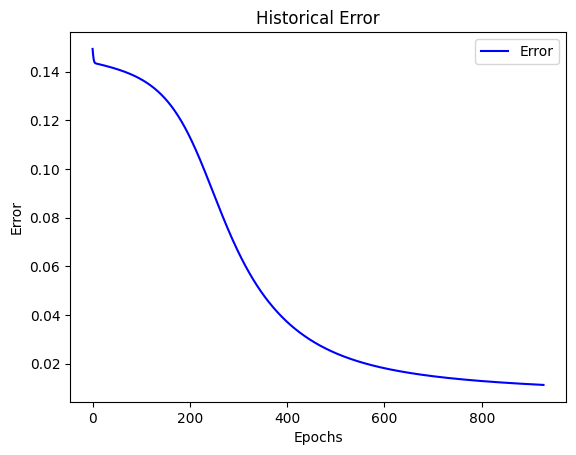

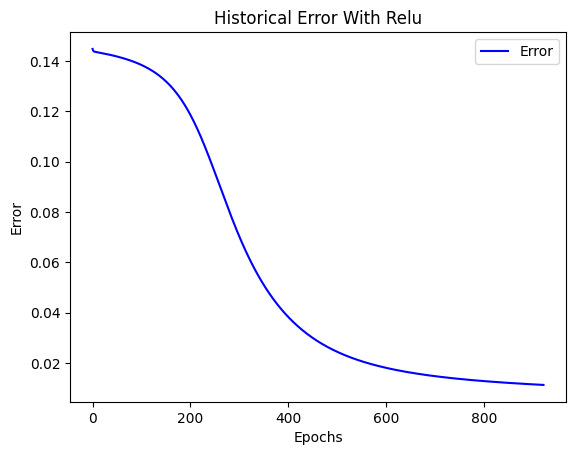

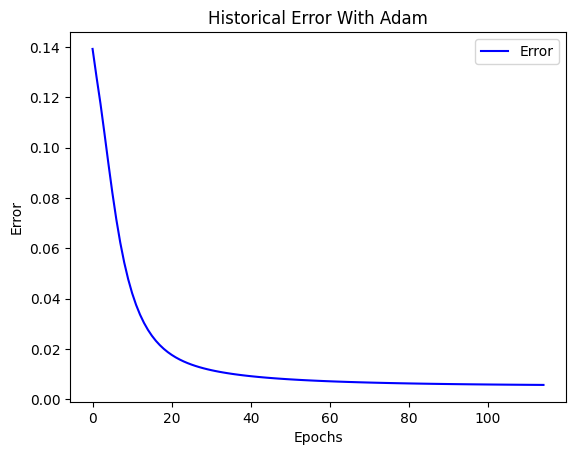

In [33]:
plt.plot(errors_glcm, c = 'b', label = 'Error')
plt.title('Historical Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

plt.plot(errors2_glcm, c = 'b', label = 'Error')
plt.title('Historical Error With Relu')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

plt.plot(errors3_glcm, c = 'b', label = 'Error')
plt.title('Historical Error With Adam')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

## Plot Historical Error Neural Network (Backpropagation) with Data Non GLCM

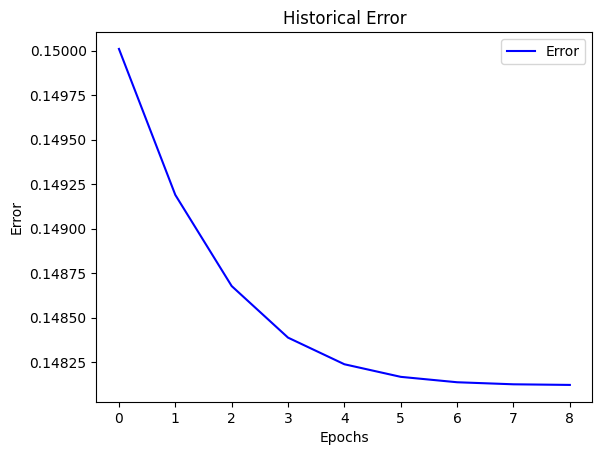

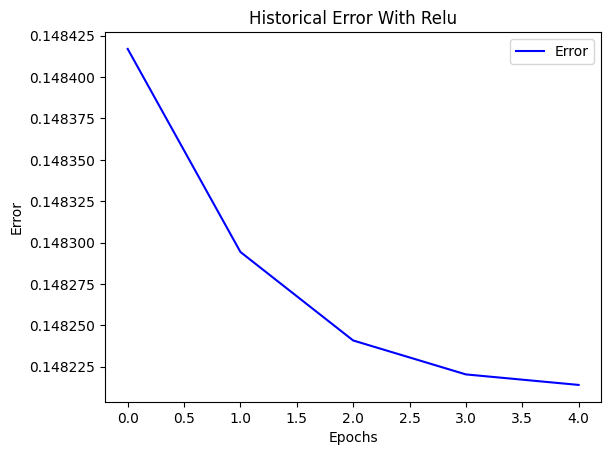

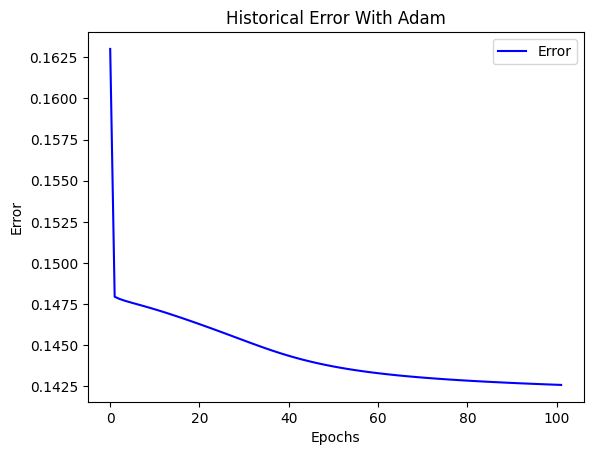

In [34]:
plt.plot(errors_non_glcm, c = 'b', label = 'Error')
plt.title('Historical Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

plt.plot(errors2_non_glcm, c = 'b', label = 'Error')
plt.title('Historical Error With Relu')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

plt.plot(errors3_non_glcm, c = 'b', label = 'Error')
plt.title('Historical Error With Adam')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

# Comparison

## Comparation With Data GLCM

In [35]:
# Prediction Backpro
predictions = model_glcm.forward(x_test_std_g)
# Prediction Backpro With Relu
predictions2 = model2_glcm.forward(x_test_std_g)
# Prediction Backpro With Adam
predictions3 = model3_glcm.forward(x_test_std_g)

print("Predicted output: \n" + str(model_glcm.forward(x_test_std_g).T))
print("Prediction Backpro With Relu output: \n" + str(model2_glcm.forward(x_test_std_g).T))
print("Prediction Backpro With Adam output: \n" + str(model3_glcm.forward(x_test_std_g).T))

Predicted output: 
[[0.93610206 0.95662208 0.93725594 0.96305568 0.94347396 0.94145968
  0.96803292 0.98614211 0.97270928 0.98704355 0.97486733 0.95343886
  0.95689638 0.98554616 0.98537201 0.62703185 0.98544096 0.83558564
  0.90467869 0.94618871 0.91321706 0.96932897 0.97728262 0.95864829
  0.04253851 0.95656474 0.96528748 0.94001667 0.97021884 0.95840446
  0.952887   0.94236923 0.95855886 0.96310563 0.02943464 0.92461356
  0.98219178 0.94815597 0.97093994 0.98765276 0.95459883 0.97374057
  0.95154571 0.95156743 0.93479239 0.9299727  0.96945853 0.87866377
  0.94128871 0.01645072 0.540338   0.94873338 0.96300709 0.98432286
  0.97048905 0.89498614 0.93015569 0.97334925 0.02367831 0.98470385
  0.96824999 0.98496372 0.94353577 0.97014945 0.97494516 0.94657526
  0.98720575 0.94713536 0.16101471 0.9069158  0.98390138 0.98337922
  0.74748529 0.92402099 0.95801419 0.98685999 0.97189822 0.96171567
  0.9687439  0.02189142 0.95133686 0.93092746 0.98388076 0.92133093
  0.91354542 0.9638346  0.328

In [36]:
# Denormalisasi data prediksi
predicted_1 = []
for i in range(len(predictions)):
    predicted_1.append([predictions[i][0] * (np.max(y_g) - np.min(y_g)) + np.min(y_g)])

# Denormalisasi data prediksi Backpro With Relu
predicted_2 = []
for i in range(len(predictions2)):
    predicted_2.append([predictions2[i][0] * (np.max(y_g) - np.min(y_g)) + np.min(y_g)])

# Denormalisasi data prediksi Backpro With Adam
predicted_3 = []
for i in range(len(predictions3)):
    predicted_3.append([predictions3[i][0] * (np.max(y_g) - np.min(y_g)) + np.min(y_g)])

# Denormalisasi data aktual
actual_1 = []
for i in range(len(y_test_g)):
    actual_1.append([y_test_g[i] * (np.max(y_g) - np.min(y_g)) + np.min(y_g)])

In [37]:
print("Data Predicted Backpro output: \n" + str(predicted_1))
print("Data Predicted Backpro With Relu output: \n" +  str(predicted_2))
print("Data Predicted Backpro With Adam output: \n" +  str(predicted_3))

print("Data Actual: \n" +  str(actual_1))

Data Predicted Backpro output: 
[[0.9361020637889812], [0.9566220840922731], [0.9372559395918626], [0.9630556801133999], [0.9434739612934231], [0.941459680873196], [0.9680329213103454], [0.9861421147436771], [0.972709275367251], [0.9870435505196464], [0.9748673291095142], [0.9534388640834935], [0.9568963836263336], [0.9855461616784857], [0.9853720053278497], [0.6270318498018761], [0.9854409630856564], [0.8355856403487633], [0.9046786942251804], [0.9461887066754276], [0.9132170619525983], [0.969328974943417], [0.97728262281503], [0.9586482935929163], [0.042538510447429255], [0.9565647448788783], [0.9652874754376776], [0.9400166688766916], [0.9702188424284883], [0.9584044621991217], [0.9528869965776751], [0.9423692318327591], [0.9585588636292226], [0.9631056276118228], [0.029434635872778697], [0.9246135558984644], [0.9821917843539294], [0.9481559704121566], [0.9709399385207204], [0.987652756771756], [0.954598829905688], [0.9737405698610777], [0.9515457114016657], [0.9515674280502388], [0

## Comparation With Data Non GLCM

In [38]:
# Prediction Backpro
predictions_ng = model_non_glcm.forward(x_test_std_ng)
# Prediction Backpro With Relu
predictions2_ng = model2_non_glcm.forward(x_test_std_ng)
# Prediction Backpro With Adam
predictions3_ng = model3_non_glcm.forward(x_test_std_ng)

print("Predicted output: \n" + str(model_non_glcm.forward(x_test_std_ng).T))
print("Prediction Backpro With Relu output: \n" + str(model2_non_glcm.forward(x_test_std_ng).T))
print("Prediction Backpro With Adam output: \n" + str(model3_non_glcm.forward(x_test_std_ng).T))

Predicted output: 
[[0.8475835  0.83302448 0.83312096 0.84716618 0.84367184 0.85085736
  0.82232046 0.78135462 0.78716953 0.78019408 0.78983703 0.8423639
  0.83447753 0.78272764 0.78228467 0.82386025 0.78271644 0.83774803
  0.8291276  0.85420294 0.85038367 0.83166142 0.78571234 0.82462821
  0.82702795 0.8413944  0.84396149 0.83683233 0.79445741 0.85314041
  0.85064589 0.8524518  0.80523501 0.80847402 0.83867718 0.8502164
  0.7899636  0.81141812 0.853038   0.77985949 0.84383091 0.7915963
  0.85515922 0.83561697 0.84797865 0.853523   0.83126819 0.82798954
  0.80383852 0.80726816 0.81535841 0.83695036 0.81538645 0.78137642
  0.80515975 0.84761796 0.84883073 0.80624392 0.81795366 0.78207965
  0.81192535 0.78201637 0.85093946 0.85439423 0.80475439 0.85363251
  0.7798425  0.85406996 0.81693212 0.8325187  0.78851175 0.78260642
  0.81811464 0.8521555  0.84478567 0.78008464 0.81071723 0.82067179
  0.83873326 0.79563587 0.83617137 0.81991517 0.7821327  0.8457637
  0.82262462 0.84455973 0.8019486

In [39]:
# Denormalisasi data prediksi
predicted_1_ng = []
for i in range(len(predictions_ng)):
    predicted_1_ng.append([predictions_ng[i][0] * (np.max(y_ng) - np.min(y_ng)) + np.min(y_ng)])

# Denormalisasi data prediksi Backpro With Relu
predicted_2_ng = []
for i in range(len(predictions2_ng)):
    predicted_2_ng.append([predictions2_ng[i][0] * (np.max(y_ng) - np.min(y_ng)) + np.min(y_ng)])

# Denormalisasi data prediksi Backpro With Adam
predicted_3_ng = []
for i in range(len(predictions3_ng)):
    predicted_3_ng.append([predictions3_ng[i][0] * (np.max(y_ng) - np.min(y_ng)) + np.min(y_ng)])

# Denormalisasi data aktual
actual_1_ng = []
for i in range(len(y_test_ng)):
    actual_1_ng.append([y_test_ng[i] * (np.max(y_ng) - np.min(y_ng)) + np.min(y_ng)])

In [40]:
print("Data Predicted Backpro output: \n" + str(predicted_1_ng))
print("Data Predicted Backpro With Relu output: \n" +  str(predicted_2_ng))
print("Data Predicted Backpro With Adam output: \n" +  str(predicted_3_ng))

print("Data Actual: \n" +  str(actual_1_ng))

Data Predicted Backpro output: 
[[0.8475835005583754], [0.8330244829823638], [0.8331209612469352], [0.8471661764869042], [0.843671841597302], [0.8508573608208717], [0.8223204616702845], [0.7813546213763761], [0.787169532405703], [0.7801940769957902], [0.7898370256703932], [0.8423638981904624], [0.8344775341943329], [0.7827276380716073], [0.7822846670765131], [0.8238602497867392], [0.7827164382999977], [0.8377480328267847], [0.8291275975909844], [0.8542029391020729], [0.8503836684294553], [0.8316614228795314], [0.7857123408056241], [0.8246282089096127], [0.8270279489126657], [0.8413943966755106], [0.8439614872969297], [0.836832331324654], [0.7944574051085362], [0.8531404144529592], [0.8506458867687814], [0.8524517960354043], [0.8052350105874183], [0.8084740227349885], [0.8386771772054985], [0.8502164048467812], [0.7899635960776397], [0.8114181172219961], [0.8530380030826534], [0.7798594883943076], [0.8438309072029757], [0.7915963046135518], [0.855159223156975], [0.8356169704061568], [0.

# Plot Box Comparation Results Backpro

## Plot Box Comparation Results Data GLCM

In [41]:
predicted_1
predicted_2
predicted_3
actual_1

predicted_1_ng
predicted_2_ng
predicted_3_ng
actual_1_ng

[[1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [0],
 [0],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [0],
 [0],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [0],
 [1],
 [0],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1]

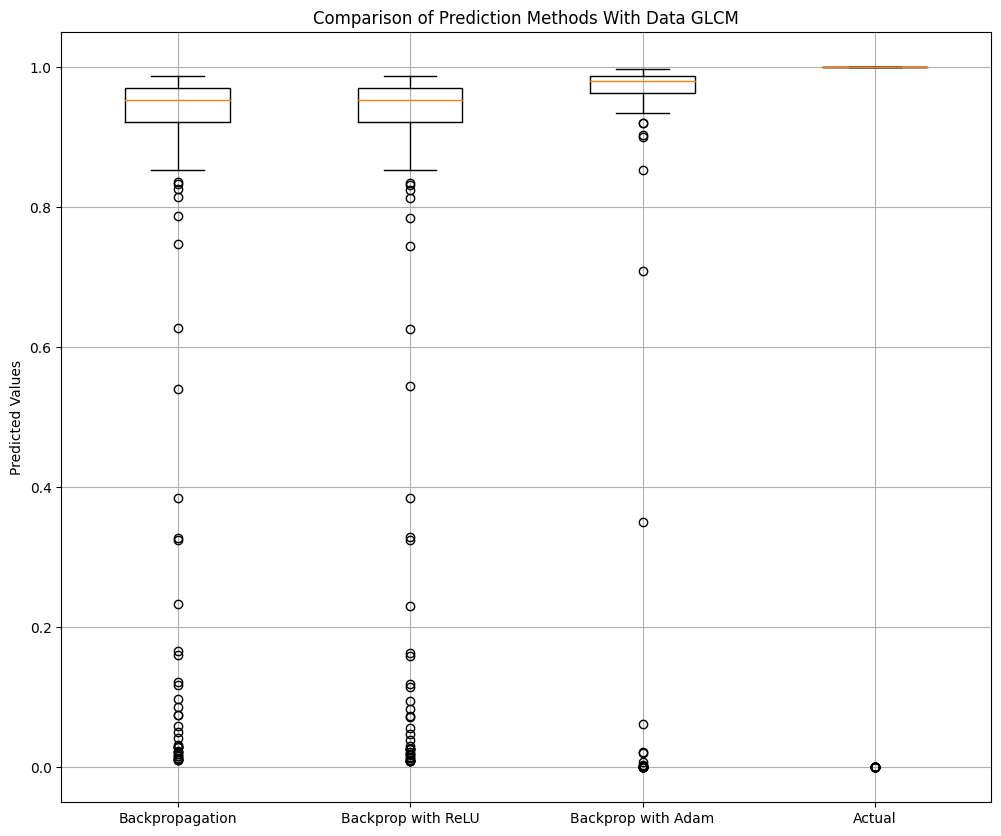

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Flatten the arrays for easier processing
y_pred = np.array(predicted_1).flatten()
y_pred_relu = np.array(predicted_2).flatten()
y_pred_adam = np.array(predicted_3).flatten()
y_val = np.array(actual_1).flatten()

# Prepare the data for plotting
data = [y_pred, y_pred_relu, y_pred_adam, y_val]
labels = ['Backpropagation', 'Backprop with ReLU', 'Backprop with Adam', 'Actual']

# Create a figure and axis for the plot
plt.figure(figsize=(12, 10))
plt.boxplot(data, labels=labels)

# Set plot details
plt.title('Comparison of Prediction Methods With Data GLCM')
plt.ylabel('Predicted Values')
plt.grid(True)

# Show the plot
plt.show()

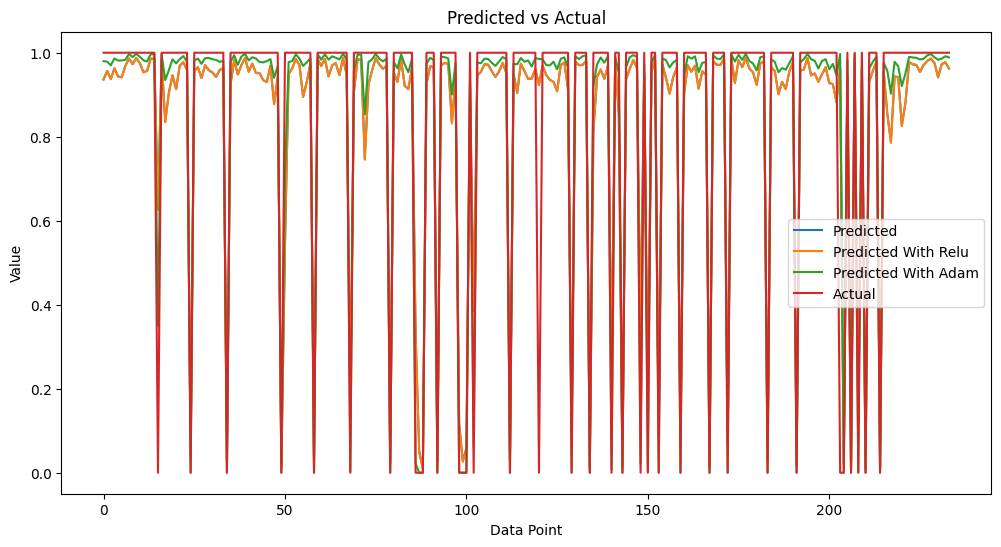

In [43]:
# Plot hasil prediksi dan data aktual
plt.figure(figsize=(12, 6))
plt.plot(predicted_1, label='Predicted')
plt.plot(predicted_2, label='Predicted With Relu')
plt.plot(predicted_3, label='Predicted With Adam')
plt.plot(actual_1, label='Actual')
plt.title('Predicted vs Actual')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()
plt.show()

## Plot Box Comparation Results Data Non GLCM

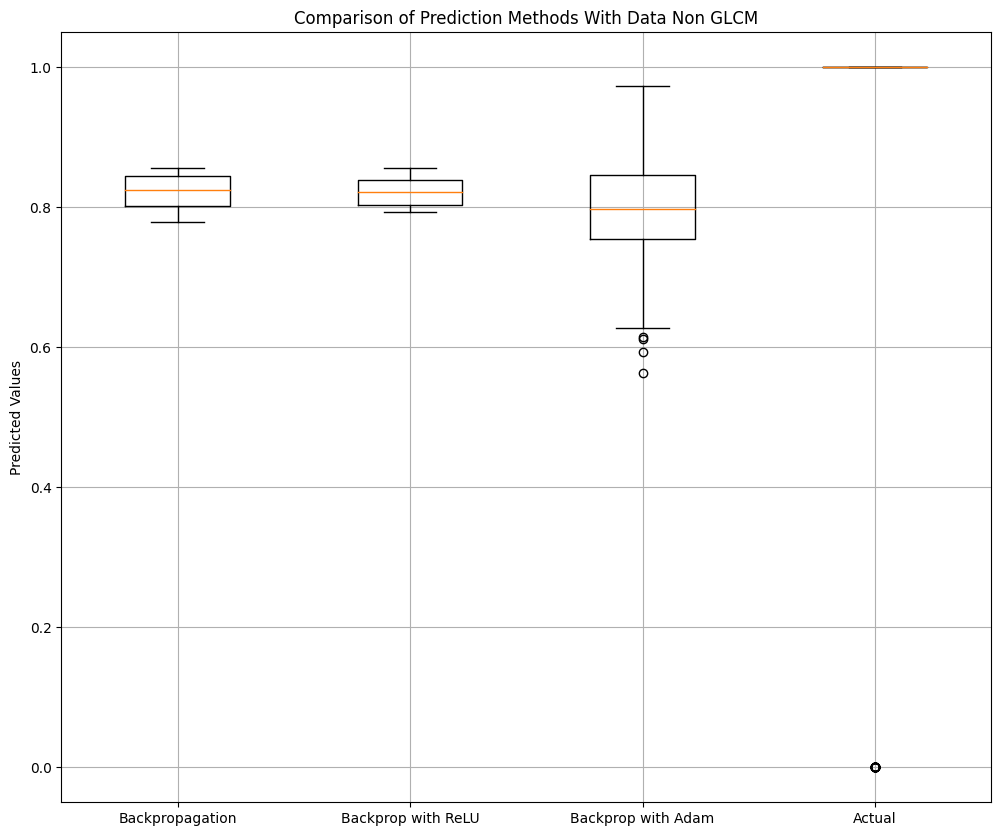

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Flatten the arrays for easier processing
y_pred_ng = np.array(predicted_1_ng).flatten()
y_pred_relu_ng = np.array(predicted_2_ng).flatten()
y_pred_adam_ng = np.array(predicted_3_ng).flatten()
y_val_ng = np.array(actual_1_ng).flatten()

# Prepare the data for plotting
data_ng = [y_pred_ng, y_pred_relu_ng, y_pred_adam_ng, y_val_ng]
labels_ng = ['Backpropagation', 'Backprop with ReLU', 'Backprop with Adam', 'Actual']

# Create a figure and axis for the plot
plt.figure(figsize=(12, 10))
plt.boxplot(data_ng, labels=labels_ng)

# Set plot details
plt.title('Comparison of Prediction Methods With Data Non GLCM')
plt.ylabel('Predicted Values')
plt.grid(True)

# Show the plot
plt.show()

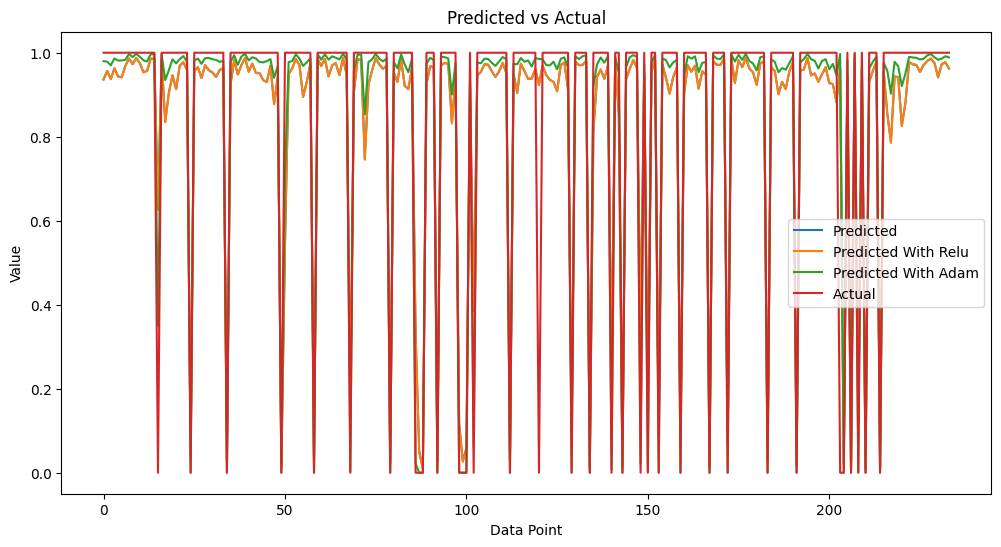

In [45]:
# Plot hasil prediksi dan data aktual
plt.figure(figsize=(12, 6))
plt.plot(predicted_1, label='Predicted')
plt.plot(predicted_2, label='Predicted With Relu')
plt.plot(predicted_3, label='Predicted With Adam')
plt.plot(actual_1, label='Actual')
plt.title('Predicted vs Actual')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()
plt.show()

## Confusion Matrix GLCM Data

In [46]:
# Inisialisasi list hasil
y_pred = []
y_pred_relu = []
y_pred_adam = []

for sublist in predicted_1:
    for pred in sublist:
        if pred < 0.5:
            y_pred.append(0)
        else:
            y_pred.append(1)

for sublist in predicted_2:
    for pred in sublist:
        if pred < 0.5:
            y_pred_relu.append(0)
        else:
            y_pred_relu.append(1)

for sublist in predicted_3:
    for pred in sublist:
        if pred < 0.5:
            y_pred_adam.append(0)
        else:
            y_pred_adam.append(1)

y_val = []  # Inisialisasi list hasil

for sublist in actual_1:
    for act in sublist:
        if act < 0.5:
            y_val.append(0)
        else:
            y_val.append(1)

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
# Menghitung metrik evaluasi
accuracy = accuracy_score(y_val, y_pred)
accuracy_relu = accuracy_score(y_val, y_pred_relu)
accuracy_adam = accuracy_score(y_val, y_pred_adam)

# Menampilkan hasil
print("Akurasi:", accuracy)
print("Akurasi With Relu:", accuracy_relu)
print("Akurasi With Adam:", accuracy_adam)

Akurasi: 0.9871794871794872
Akurasi With Relu: 0.9871794871794872
Akurasi With Adam: 0.9914529914529915


In [48]:
data_test = dfng.tail(234)

# Menghilangkan tanda kurung dengan list comprehension
label_g = [x[0] for x in actual_1]

In [49]:
# Check the lengths
print(f"Length of y_pred: {len(y_pred)}")
print(f"Length of y_pred_relu: {len(y_pred_relu)}")
print(f"Length of y_pred_adam: {len(y_pred_adam)}")
print(f"Length of label_g: {len(label_g)}")
print(f"Length of data_test: {len(data_test)}")

Length of y_pred: 234
Length of y_pred_relu: 234
Length of y_pred_adam: 234
Length of label_g: 234
Length of data_test: 234


In [50]:
# Ensure lengths match
if len(y_pred) == len(data_test) == len(y_pred_relu) == len(y_pred_adam) == len(label_g):
    data_test['Prediksi'] = y_pred
    data_test['Prediksi With Relu'] = y_pred_relu
    data_test['Prediksi With Adam'] = y_pred_adam
    data_test['Label'] = label_g
    data_test['Output'] = data_test['Label'].replace({0: 'No', 1: 'Yes'})
else:
    print("The lengths of the arrays do not match. Please ensure all arrays have the same length as data_test.")

<ipython-input-50-4434ff172168>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['Prediksi'] = y_pred
<ipython-input-50-4434ff172168>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['Prediksi With Relu'] = y_pred_relu
<ipython-input-50-4434ff172168>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [51]:
data_test

,Energy,Contrast,Homogeneity,Entropy,Label,Prediksi,Prediksi With Relu,Prediksi With Adam,Output
546,72910.0,12966.704935,0.993338,0.588247,1,1,1,1,Yes
547,546.0,148.588604,0.999523,0.016211,1,1,1,1,Yes
548,88176.0,15132.231813,0.993325,0.658166,1,1,1,1,Yes
549,67770.0,10321.638240,0.989267,0.497473,1,1,1,1,Yes
550,37091.0,7721.850137,0.994170,0.400801,1,1,1,1,Yes
...,...,...,...,...,...,...,...,...,...
775,28795.0,4378.036464,0.994682,0.260311,1,1,1,1,Yes
776,74465.0,13163.588586,0.994173,0.594753,1,1,1,1,Yes
777,8872.0,1420.377997,0.997834,0.107022,1,1,1,1,Yes
778,222.0,35.771570,0.999772,0.004682,1,1,1,1,Yes


In [52]:
from sklearn.metrics import confusion_matrix, classification_report

# List of predictions and their descriptions
predictions = [y_pred, y_pred_relu, y_pred_adam]
descriptions = ['Standard', 'ReLU Activated', 'Adam Optimized']

# Loop through each set of predictions
for pred, desc in zip(predictions, descriptions):
    print(f"\nResults for {desc} Predictions:")

    # Compute the confusion matrix
    confusion = confusion_matrix(y_val, pred)
    print("\nConfusion Matrix:")
    print(confusion)

    # Generate a classification report
    classification_rep = classification_report(y_val, pred, zero_division=0)
    print("\nClassification Report:")
    print(classification_rep)

    # Show TP, TN, FP, FN
    tn, fp, fn, tp = confusion.ravel()
    print("\nTrue Negatives: ", tn)
    print("False Positives: ", fp)
    print("False Negatives: ", fn)
    print("True Positives: ", tp)


Results for Standard Predictions:

Confusion Matrix:
[[ 32   3]
 [  0 199]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.96        35
           1       0.99      1.00      0.99       199

    accuracy                           0.99       234
   macro avg       0.99      0.96      0.97       234
weighted avg       0.99      0.99      0.99       234


True Negatives:  32
False Positives:  3
False Negatives:  0
True Positives:  199

Results for ReLU Activated Predictions:

Confusion Matrix:
[[ 32   3]
 [  0 199]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.96        35
           1       0.99      1.00      0.99       199

    accuracy                           0.99       234
   macro avg       0.99      0.96      0.97       234
weighted avg       0.99      0.99      0.99       234


True Negatives:  32
False Positives:  3
False Negatives

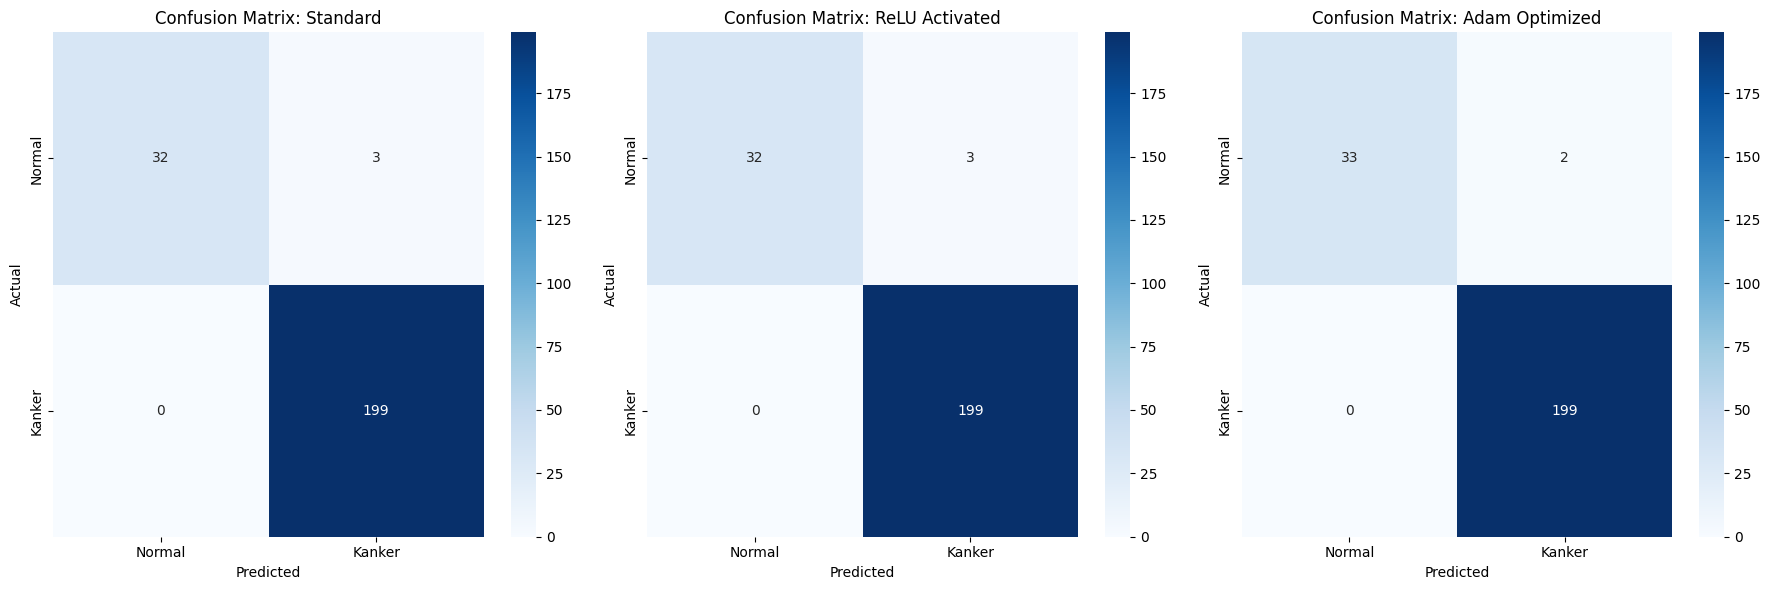

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Data prediksi dan deskripsi masing-masing
predictions = [y_pred, y_pred_relu, y_pred_adam]
descriptions = ['Standard', 'ReLU Activated', 'Adam Optimized']

# Set label names for classes
class_names = ["Normal", "Kanker"]

# Buat figure dan axes untuk subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Sesuaikan dengan jumlah prediksi

# Loop through each set of predictions to plot the confusion matrix
for ax, pred, desc in zip(axes.flatten(), predictions, descriptions):
    # Compute the confusion matrix
    confusion = confusion_matrix(y_val, pred)

    # Plot confusion matrix
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)

    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'Confusion Matrix: {desc}')

# Tampilkan semua plot
plt.tight_layout()
plt.show()


In [54]:
import pandas as pd

# Create a DataFrame to save predictions
predictions_df = pd.DataFrame({'Actual': y_val, 'Predicted': y_pred, 'Predicted With Relu': y_pred_relu, 'Predicted With Adam': y_pred_adam})
predictions_df.to_excel('predictions.xlsx', index=False)
# predictions_df.to_csv('predictions.csv', index=False)

# Display the DataFrame
print("\nPredictions saved to 'predictions.xlsx':")

# Mengubah opsi tampilan pandas
pd.set_option('display.max_rows', None)
print(predictions_df)

# Now you can access TP, TN, FN, FP, and the predictions saved in 'predictions.csv' for further analysis or reporting.



Predictions saved to 'predictions.xlsx':
     Actual  Predicted  Predicted With Relu  Predicted With Adam
0         1          1                    1                    1
1         1          1                    1                    1
2         1          1                    1                    1
3         1          1                    1                    1
4         1          1                    1                    1
5         1          1                    1                    1
6         1          1                    1                    1
7         1          1                    1                    1
8         1          1                    1                    1
9         1          1                    1                    1
10        1          1                    1                    1
11        1          1                    1                    1
12        1          1                    1                    1
13        1          1                    1     

In [55]:
from google.colab import files
files.download('predictions.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Confusion Matrix With Non GLCM Data

In [56]:

# Inisialisasi list hasil
y_pred_ng = []
y_pred_relu_ng = []
y_pred_adam_ng = []

for sublist in predicted_1_ng:
    for pred in sublist:
        if pred < 0.5:
            y_pred_ng.append(0)
        else:
            y_pred_ng.append(1)

for sublist in predicted_2_ng:
    for pred in sublist:
        if pred < 0.5:
            y_pred_relu_ng.append(0)
        else:
            y_pred_relu_ng.append(1)

for sublist in predicted_3_ng:
    for pred in sublist:
        if pred < 0.5:
            y_pred_adam_ng.append(0)
        else:
            y_pred_adam_ng.append(1)

y_val_ng = []  # Inisialisasi list hasil

for sublist in actual_1_ng:
    for act in sublist:
        if act < 0.5:
            y_val_ng.append(0)
        else:
            y_val_ng.append(1)

In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
# Menghitung metrik evaluasi
accuracy_ng = accuracy_score(y_val_ng, y_pred_ng)
accuracy_relu_ng = accuracy_score(y_val_ng, y_pred_relu_ng)
accuracy_adam_ng = accuracy_score(y_val_ng, y_pred_adam_ng)

# Menampilkan hasil
print("Akurasi:", accuracy_ng)
print("Akurasi With Relu:", accuracy_relu_ng)
print("Akurasi With Adam:", accuracy_adam_ng)

Akurasi: 0.8504273504273504
Akurasi With Relu: 0.8504273504273504
Akurasi With Adam: 0.8504273504273504


In [58]:
data_test_ng = dfng.tail(234)

# Menghilangkan tanda kurung dengan list comprehension
label_ng = [x[0] for x in actual_1_ng]

In [59]:
data_test_ng['Prediksi'] = y_pred_ng
data_test_ng['Prediksi With Relu'] = y_pred_relu_ng
data_test_ng['Prediksi With Adam'] = y_pred_adam_ng
data_test_ng['Label'] = label_ng
data_test_ng['Output'] = data_test_ng['Label'].replace({0: 'No', 1: 'Yes'})

data_test_ng

<ipython-input-59-90273fd4bc9b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_ng['Prediksi'] = y_pred_ng
<ipython-input-59-90273fd4bc9b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_ng['Prediksi With Relu'] = y_pred_relu_ng
<ipython-input-59-90273fd4bc9b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

,Energy,Contrast,Homogeneity,Entropy,Label,Prediksi,Prediksi With Relu,Prediksi With Adam,Output
546,72910.0,12966.704935,0.993338,0.588247,1,1,1,1,Yes
547,546.0,148.588604,0.999523,0.016211,1,1,1,1,Yes
548,88176.0,15132.231813,0.993325,0.658166,1,1,1,1,Yes
549,67770.0,10321.638240,0.989267,0.497473,1,1,1,1,Yes
550,37091.0,7721.850137,0.994170,0.400801,1,1,1,1,Yes
551,50514.0,10815.461299,0.990014,0.514934,1,1,1,1,Yes
552,96164.0,14997.262545,0.988448,0.653909,1,1,1,1,Yes
553,65801.0,12472.248293,0.991681,0.571765,1,1,1,1,Yes
554,16016.0,3698.766544,0.996460,0.228474,1,1,1,1,Yes
555,166996.0,14293.064120,0.993647,0.631487,1,1,1,1,Yes


In [60]:
from sklearn.metrics import confusion_matrix, classification_report

# List of predictions and their descriptions
predictions_ng = [y_pred_ng, y_pred_relu_ng, y_pred_adam_ng]
descriptions_ng = ['Standard', 'ReLU Activated', 'Adam Optimized']

# Loop through each set of predictions
for pred, desc in zip(predictions_ng, descriptions_ng):
    print(f"\nResults for {desc} Predictions:")

    # Compute the confusion matrix
    confusion = confusion_matrix(y_val_ng, pred)
    print("\nConfusion Matrix:")
    print(confusion)

    # Generate a classification report
    classification_rep_ng = classification_report(y_val_ng, pred, zero_division=0)
    print("\nClassification Report:")
    print(classification_rep_ng)

    # Show TP, TN, FP, FN
    tn, fp, fn, tp = confusion.ravel()
    print("\nTrue Negatives: ", tn)
    print("False Positives: ", fp)
    print("False Negatives: ", fn)
    print("True Positives: ", tp)


Results for Standard Predictions:

Confusion Matrix:
[[  0  35]
 [  0 199]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.85      1.00      0.92       199

    accuracy                           0.85       234
   macro avg       0.43      0.50      0.46       234
weighted avg       0.72      0.85      0.78       234


True Negatives:  0
False Positives:  35
False Negatives:  0
True Positives:  199

Results for ReLU Activated Predictions:

Confusion Matrix:
[[  0  35]
 [  0 199]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.85      1.00      0.92       199

    accuracy                           0.85       234
   macro avg       0.43      0.50      0.46       234
weighted avg       0.72      0.85      0.78       234


True Negatives:  0
False Positives:  35
False Negatives

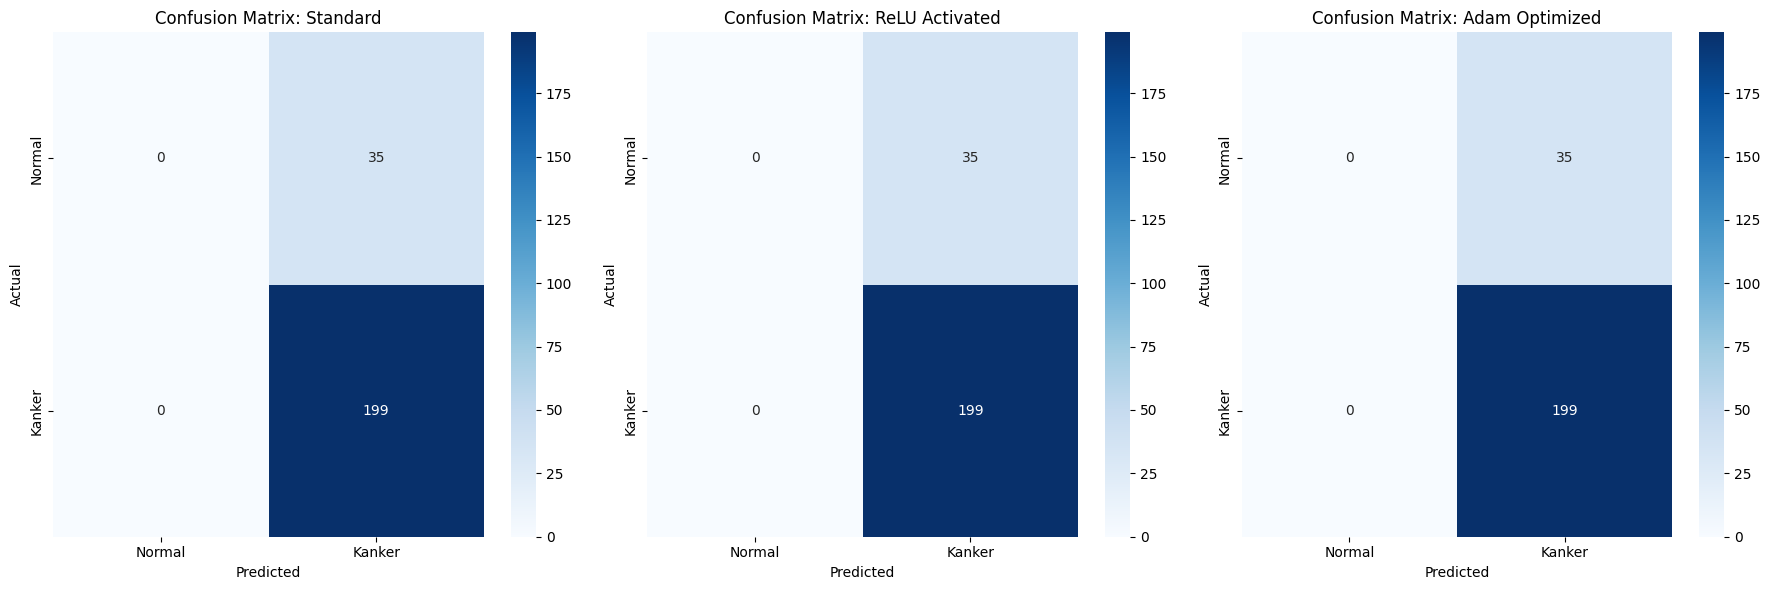

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Data prediksi dan deskripsi masing-masing
predictions_ng = [y_pred_ng, y_pred_relu_ng, y_pred_adam_ng]
descriptions_ng = ['Standard', 'ReLU Activated', 'Adam Optimized']

# Set label names for classes
class_names = ["Normal", "Kanker"]

# Buat figure dan axes untuk subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Sesuaikan dengan jumlah prediksi

# Loop through each set of predictions_ng to plot the confusion matrix
for ax, pred, desc in zip(axes.flatten(), predictions_ng, descriptions_ng):
    # Compute the confusion matrix
    confusion_ng = confusion_matrix(y_val, pred)

    # Plot confusion matrix
    sns.heatmap(confusion_ng, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)

    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'Confusion Matrix: {desc}')

# Tampilkan semua plot
plt.tight_layout()
plt.show()
